In [4]:
from everywhereml.data import ImageDataset
from everywhereml.data.collect import MjpegCollector

base_folder = 'IMG_COLLECTED'

try:
   
    image_dataset = ImageDataset.from_nested_folders(
        name='Boards', 
        base_folder=base_folder
    )
except FileNotFoundError:
   
    mjpeg_collector = MjpegCollector(address='http://192.168.1.149')
    image_dataset = mjpeg_collector.collect_many_classes(
        dataset_name='Boards', 
        base_folder=base_folder,
        duration=40
    )




print(image_dataset)

image_dataset.preview(
    samples_per_class=10, 
    rows_per_class=2, 
    figsize=(20, 10)
)

This is an interactive data capturing procedure.
Keep in mind that as soon as you will enter a class name, the capturing will start, so be ready!
Captured 0 images
creating IMG_COLLECTED folder
creating IMG_COLLECTED/Keys folder


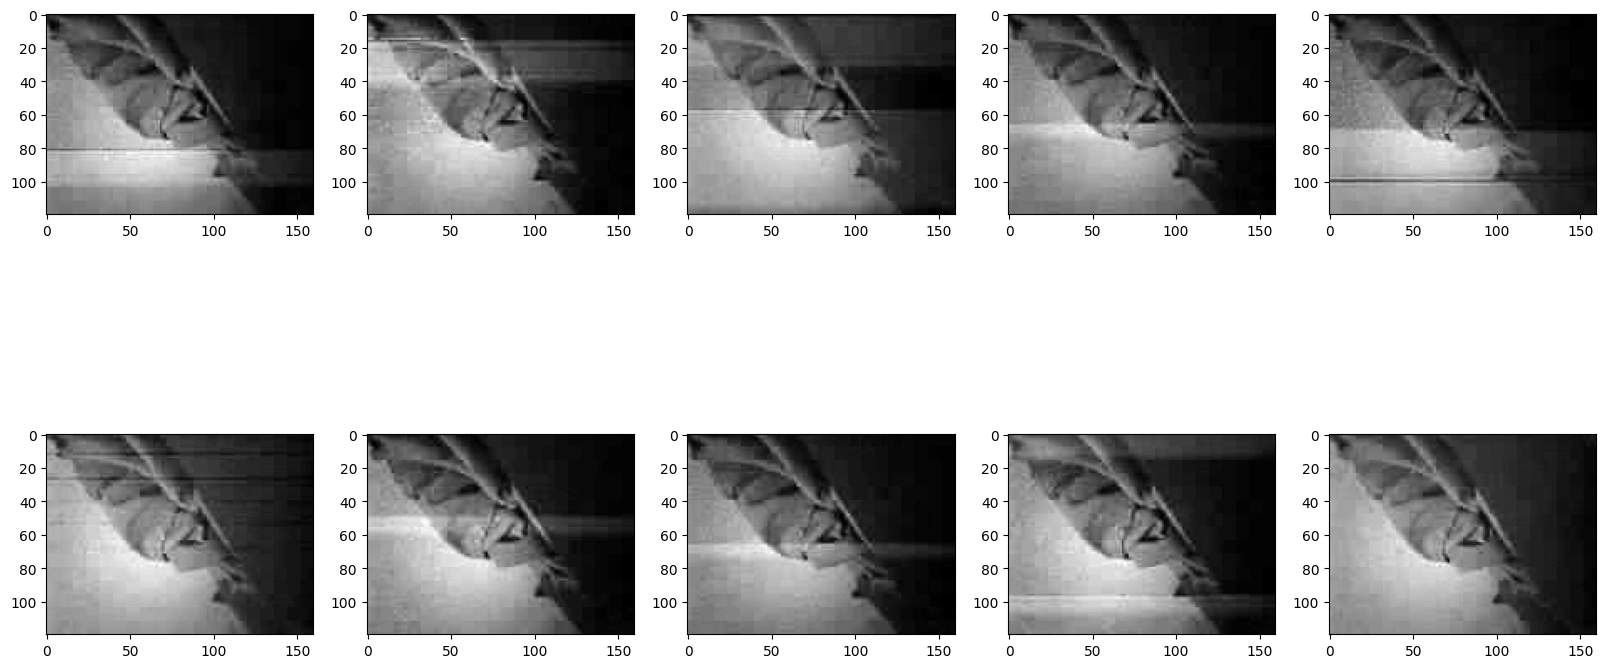

In [36]:
"""
Image classification with HOG works on grayscale images at the moment
So convert images to grayscale in the range 0-255
"""
image_dataset = image_dataset.gray().uint8()

"""
Preview grayscale images
"""
image_dataset.preview(
    samples_per_class=10, 
    rows_per_class=2, 
    figsize=(20, 10), 
    cmap='gray'
)





In [37]:
"""
Create an object detection pipeline with HOG feature extractor
"""
from everywhereml.preprocessing.image.object_detection import HogPipeline
from everywhereml.preprocessing.image.transform import Resize

pipeline = HogPipeline(
    transforms=[
        Resize(width=40, height=30)
    ]
)

# Convert images to feature vectors
feature_dataset = pipeline.fit_transform(image_dataset)
feature_dataset.describe()


HOG: 100%|██████████| 76/76 [00:00<00:00, 407.50it/s]


,hog0,hog1,hog2,hog3,hog4,hog5,hog6,hog7,hog8,hog9,...,hog126,hog127,hog128,hog129,hog130,hog131,hog132,hog133,hog134,target
count,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,...,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.0
mean,0.226566,0.139361,0.121612,0.247187,0.469589,0.873204,0.567366,0.454345,0.101381,0.159289,...,0.000022,0.000209,0.000061,0.000524,0.093866,0.106913,0.030555,0.044340,0.154686,0.0
std,0.099933,0.104733,0.083251,0.128527,0.213945,0.167671,0.199379,0.221294,0.093854,0.089309,...,0.000190,0.001459,0.000535,0.002609,0.142926,0.150649,0.038214,0.037264,0.135232,0.0
min,0.000000,0.000000,0.000000,0.000000,0.132812,0.314318,0.097866,0.024132,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005585,0.000000,0.0
25%,0.161560,0.065884,0.049769,0.155579,0.322086,0.811817,0.414040,0.318495,0.030002,0.073354,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006907,0.017032,0.060331,0.0
50%,0.230860,0.131031,0.117455,0.256998,0.404939,0.940577,0.548400,0.416147,0.083743,0.167206,...,0.000000,0.000000,0.000000,0.000000,0.014507,0.006769,0.017960,0.033359,0.097794,0.0
75%,0.293337,0.196915,0.150276,0.345558,0.578298,1.000000,0.708385,0.575265,0.125003,0.223287,...,0.000000,0.000000,0.000000,0.000000,0.147633,0.220683,0.033512,0.058952,0.309305,0.0
max,0.449256,0.510463,0.382206,0.575958,1.000000,1.000000,1.000000,1.000000,0.372186,0.363855,...,0.001659,0.012224,0.004663,0.019915,0.767317,0.567796,0.159743,0.184651,0.465142,0.0


In [38]:

"""
Print pipeline description
"""
print(pipeline)


ImagePipeline: HogPipeline
---------
 - Resize(from=(160, 120), to=(40, 30), pixformat=gray)
 > HOG(block_size=8, bins=9, cell_size=3)


c:\Program Files\Python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)


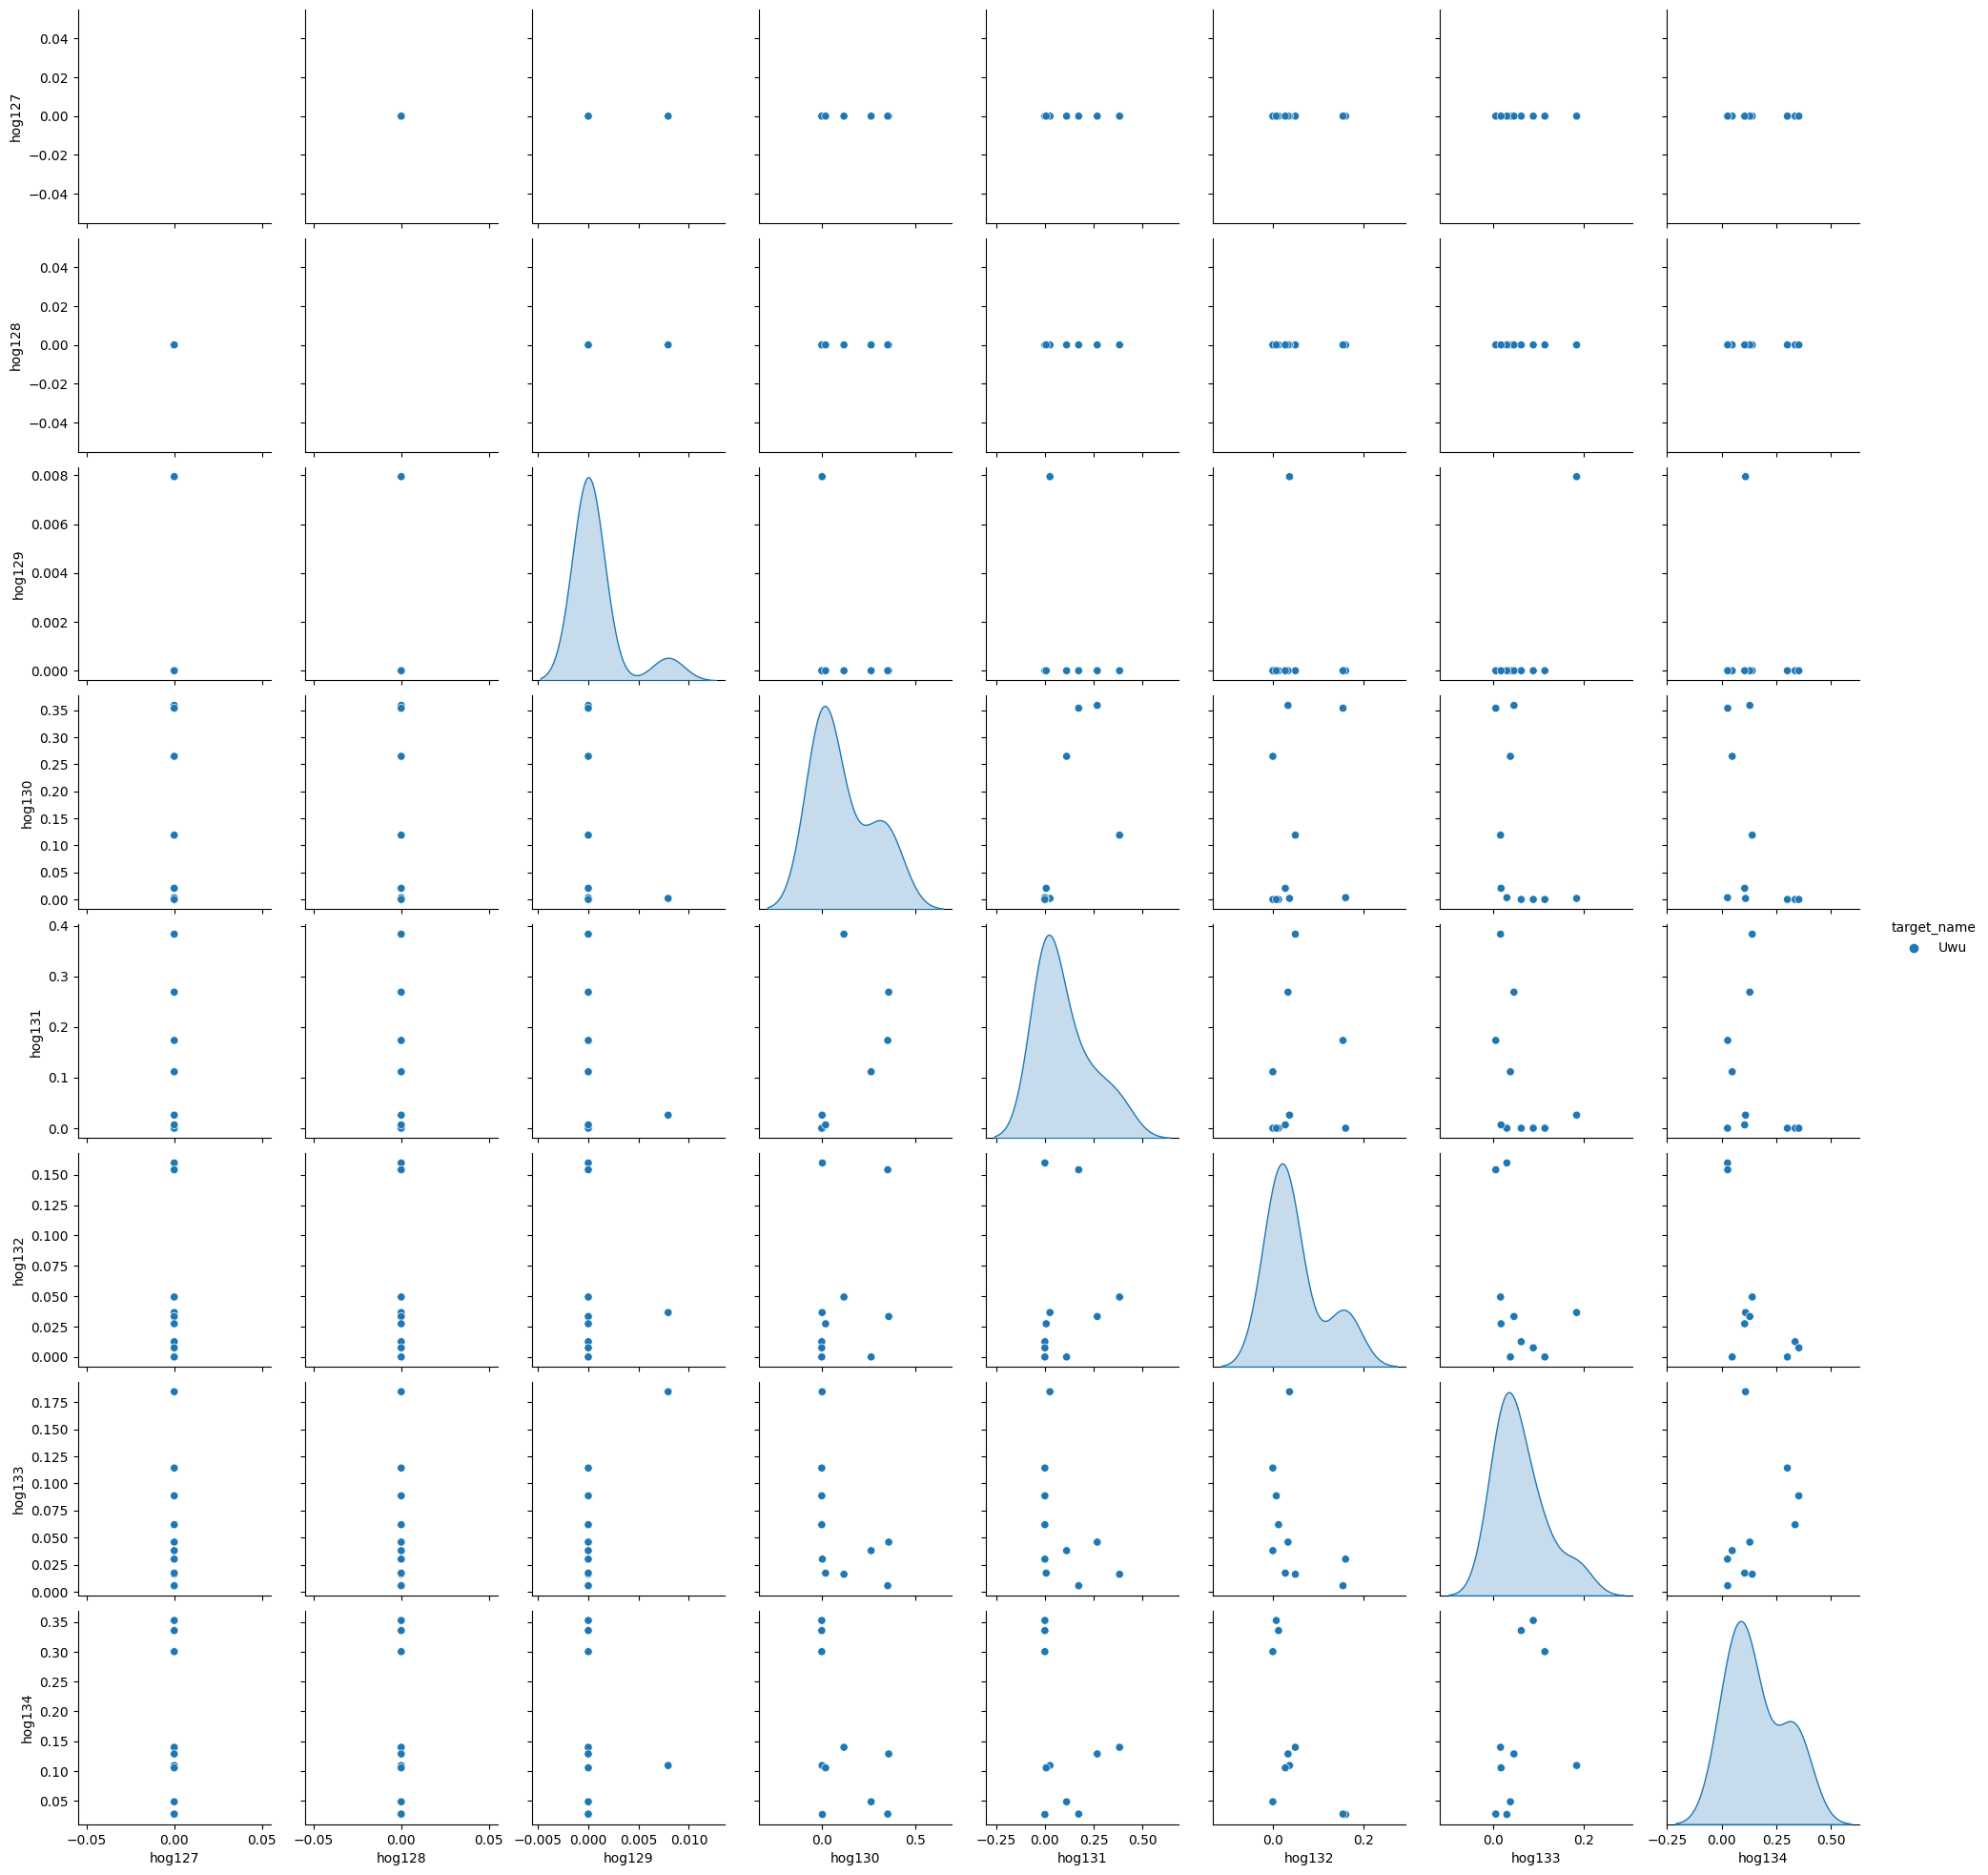

In [39]:
feature_dataset.plot.features_pairplot(n=10, k=8)

In [40]:
"""
Create and fit RandomForest classifier
"""
from everywhereml.sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=8, max_depth=40)

# fit on train split and get accuracy on the test split
train, test = feature_dataset.split(test_size=0.4)
clf.fit(train)

print('Score on test set: %.2f' % clf.score(test))

# now fit on the whole dataset
clf.fit(feature_dataset)

Score on test set: 1.00


RandomForestClassifier(base_estimator=DecisionTreeClassifier(), bootstrap=True, ccp_alpha=0.0, class_name=RandomForestClassifier, class_weight=None, criterion=gini, estimator_params=('criterion', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'min_weight_fraction_leaf', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'random_state', 'ccp_alpha'), max_depth=40, max_features=auto, max_leaf_nodes=None, max_samples=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=8, n_jobs=None, num_outputs=1, oob_score=False, package_name=everywhereml.sklearn.ensemble, random_state=None, template_folder=everywhereml/sklearn/ensemble, verbose=0, warm_start=False)

In [42]:
print(clf.to_arduino_file(
    filename='path-to-sketch/HogClassifier.h',
    instance_name='classifier', 
    class_map=feature_dataset.class_map
))

TemplateNotFound: RandomForestClassifier in ['templates\\sklearn/ensemble/cpp/arduino/RandomForestClassifier.cpp.arduino.jinja', 'templates\\sklearn/ensemble/cpp/arduino/RandomForestClassifier.cpp.jinja', 'templates\\sklearn/ensemble/cpp/arduino/RandomForestClassifier.jinja', 'templates\\sklearn/ensemble/cpp/RandomForestClassifier.cpp.arduino.jinja', 'templates\\sklearn/ensemble/cpp/RandomForestClassifier.cpp.jinja', 'templates\\sklearn/ensemble/cpp/RandomForestClassifier.jinja', 'templates\\sklearn/ensemble/RandomForestClassifier.cpp.arduino.jinja', 'templates\\sklearn/ensemble/RandomForestClassifier.cpp.jinja', 'templates\\sklearn/ensemble/RandomForestClassifier.jinja', 'templates\\sklearn/cpp/arduino/RandomForestClassifier.cpp.arduino.jinja', 'templates\\sklearn/cpp/arduino/RandomForestClassifier.cpp.jinja', 'templates\\sklearn/cpp/arduino/RandomForestClassifier.jinja', 'templates\\sklearn/cpp/RandomForestClassifier.cpp.arduino.jinja', 'templates\\sklearn/cpp/RandomForestClassifier.cpp.jinja', 'templates\\sklearn/cpp/RandomForestClassifier.jinja', 'templates\\sklearn/RandomForestClassifier.cpp.arduino.jinja', 'templates\\sklearn/RandomForestClassifier.cpp.jinja', 'templates\\sklearn/RandomForestClassifier.jinja', 'templates/cpp/arduino/RandomForestClassifier.cpp.arduino.jinja', 'templates/cpp/arduino/RandomForestClassifier.cpp.jinja', 'templates/cpp/arduino/RandomForestClassifier.jinja', 'templates/cpp/RandomForestClassifier.cpp.arduino.jinja', 'templates/cpp/RandomForestClassifier.cpp.jinja', 'templates/cpp/RandomForestClassifier.jinja', 'templates/RandomForestClassifier.cpp.arduino.jinja', 'templates/RandomForestClassifier.cpp.jinja', 'templates/RandomForestClassifier.jinja']

In [43]:
print(pipeline.to_arduino_file)

print(pipeline.dataset)

print(pipeline.to_arduino_file(
    filename='HogPipeline.h',
    instance_name='hog'
))


<bound method GeneratesCode.to_arduino_file of ImagePipeline: HogPipeline
---------
 - Resize(from=(160, 120), to=(40, 30), pixformat=gray)
 > HOG(block_size=8, bins=9, cell_size=3)>


TemplateNotFound: HogPipeline in ['templates\\preprocessing/image/object_detection/cpp/arduino/HogPipeline.cpp.arduino.jinja', 'templates\\preprocessing/image/object_detection/cpp/arduino/HogPipeline.cpp.jinja', 'templates\\preprocessing/image/object_detection/cpp/arduino/HogPipeline.jinja', 'templates\\preprocessing/image/object_detection/cpp/HogPipeline.cpp.arduino.jinja', 'templates\\preprocessing/image/object_detection/cpp/HogPipeline.cpp.jinja', 'templates\\preprocessing/image/object_detection/cpp/HogPipeline.jinja', 'templates\\preprocessing/image/object_detection/HogPipeline.cpp.arduino.jinja', 'templates\\preprocessing/image/object_detection/HogPipeline.cpp.jinja', 'templates\\preprocessing/image/object_detection/HogPipeline.jinja', 'templates\\preprocessing/image/cpp/arduino/HogPipeline.cpp.arduino.jinja', 'templates\\preprocessing/image/cpp/arduino/HogPipeline.cpp.jinja', 'templates\\preprocessing/image/cpp/arduino/HogPipeline.jinja', 'templates\\preprocessing/image/cpp/HogPipeline.cpp.arduino.jinja', 'templates\\preprocessing/image/cpp/HogPipeline.cpp.jinja', 'templates\\preprocessing/image/cpp/HogPipeline.jinja', 'templates\\preprocessing/image/HogPipeline.cpp.arduino.jinja', 'templates\\preprocessing/image/HogPipeline.cpp.jinja', 'templates\\preprocessing/image/HogPipeline.jinja', 'templates\\preprocessing/cpp/arduino/HogPipeline.cpp.arduino.jinja', 'templates\\preprocessing/cpp/arduino/HogPipeline.cpp.jinja', 'templates\\preprocessing/cpp/arduino/HogPipeline.jinja', 'templates\\preprocessing/cpp/HogPipeline.cpp.arduino.jinja', 'templates\\preprocessing/cpp/HogPipeline.cpp.jinja', 'templates\\preprocessing/cpp/HogPipeline.jinja', 'templates\\preprocessing/HogPipeline.cpp.arduino.jinja', 'templates\\preprocessing/HogPipeline.cpp.jinja', 'templates\\preprocessing/HogPipeline.jinja', 'templates/cpp/arduino/HogPipeline.cpp.arduino.jinja', 'templates/cpp/arduino/HogPipeline.cpp.jinja', 'templates/cpp/arduino/HogPipeline.jinja', 'templates/cpp/HogPipeline.cpp.arduino.jinja', 'templates/cpp/HogPipeline.cpp.jinja', 'templates/cpp/HogPipeline.jinja', 'templates/HogPipeline.cpp.arduino.jinja', 'templates/HogPipeline.cpp.jinja', 'templates/HogPipeline.jinja']